In [1]:
import pandas as pd

In [45]:
neko_sif = "./usecase_neko_ags/logic_model_network_neko.sif"

cascade_sif = "./usecase_neko_ags/logic_model_network_cascade.sif"

In [17]:
mapping = "./usecase_neko_ags/hgnc conversion key for comparison cascade 1 vs neko topology.xlsx"

In [4]:
def import_sif_to_df(file_path):
    # Define a dictionary to map interaction symbols to their corresponding types
    interaction_map = {
        '->': 'activation',
        '-|': 'inhibition'
    }

    # Read the file, skipping lines starting with '#'
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if not line.startswith('#'):  # Skip comment lines
                # Split the line by tab to get source, interaction, and target
                parts = line.split('\t')
                if len(parts) == 3:
                    source, interaction, target = parts
                    interaction_type = interaction_map.get(interaction, 'unknown')
                    data.append([source, interaction_type, target])

    # Create a pandas DataFrame from the data
    df = pd.DataFrame(data, columns=['Source', 'Interaction', 'Target'])
    
    return df

In [21]:
def map_nodes_and_expand_interactions(df, mapping_file):
    # Read the Excel mapping file into a DataFrame
    mapping_df = pd.read_excel(mapping_file, sheet_name=1)

    # Create a dictionary for mapping Node to HGNC_symbols
    node_map = mapping_df.set_index('Node')['HGNC_symbols'].to_dict()

    # Function to map a single value and return a list of new values
    def map_node(node):
        if node in node_map and pd.notna(node_map[node]):
            return node_map[node].split(', ')  # Split multiple symbols if present
        else:
            return [node]  # Return the original node if no mapping is found

    # Create a list to store the expanded rows
    expanded_rows = []

    # Iterate through the original DataFrame and apply the mapping
    for _, row in df.iterrows():
        source_mapped = map_node(row['Source'])
        target_mapped = map_node(row['Target'])

        # Create all combinations of source and target mappings
        for source in source_mapped:
            for target in target_mapped:
                expanded_rows.append([source, row['Interaction'], target])

    # Convert the expanded rows into a new DataFrame
    expanded_df = pd.DataFrame(expanded_rows, columns=['Source', 'Interaction', 'Target'])

    return expanded_df

In [39]:
def remove_interactions(df, terms):
    """
    Remove rows from the DataFrame where 'Source', 'Target', or 'Interaction' columns 
    contain any of the specified terms.

    Args:
    df (pandas.DataFrame): The DataFrame to be filtered.
    terms (list of str): A list of terms to remove from the interactions.

    Returns:
    pandas.DataFrame: A DataFrame with rows containing the specified terms removed.
    """
    # Join the terms into a single regex pattern
    pattern = '|'.join(terms)
    
    # Filter the DataFrame, keeping rows where the terms are NOT present in Source, Target, or Interaction
    filtered_df = df[
        ~df['Source'].str.contains(pattern, case=False, na=False) & 
        ~df['Target'].str.contains(pattern, case=False, na=False) &
        ~df['Interaction'].str.contains(pattern, case=False, na=False)
    ]
    
    return filtered_df

In [63]:
def export_to_sif(df, output_file):
    """
    Export a DataFrame with Source, Interaction, and Target columns to a .sif file, 
    converting 'activation' to '->' and 'inhibition' to '-|'.
    
    Args:
    df (pandas.DataFrame): The DataFrame to export.
    output_file (str): Path to the output .sif file.
    """
    # Ensure the DataFrame has the correct columns
    if not all(col in df.columns for col in ['Source', 'Interaction', 'Target']):
        raise ValueError("DataFrame must contain 'Source', 'Interaction', and 'Target' columns.")
    
    # Mapping for interactions
    interaction_map = {
        'activation': '->',
        'inhibition': '-|'
    }

    # Apply the mapping to the Interaction column
    df['Interaction'] = df['Interaction'].map(interaction_map).fillna(df['Interaction'])
    
    # Export to a space-separated file (sif format)
    df.to_csv(output_file, sep='\t', header=False, index=False)
    print(f"DataFrame successfully exported to {output_file}")

In [5]:
neko_net = import_sif_to_df(neko_sif)

In [46]:
cascade_net = import_sif_to_df(cascade_sif)

In [ ]:
cascade_net = remove_interactions(cascade_net, ["Antisurvival", "Prosurvival"])

In [34]:
neko_net

,Source,Interaction,Target
0,CTNNB1,activation,POU5F1
1,CTNNB1,inhibition,PPARG
2,MAP3K7,activation,TAB1
3,MAP3K7,activation,MAP2K6
4,MAP3K7,activation,MAP2K4
...,...,...,...
135,CTNNB1,activation,CCND1
136,CTNNB1,activation,TCF7L2
137,CTNNB1,activation,MYC
138,SRC,activation,CASP9


In [35]:
cascade_net

,Source,Interaction,Target
0,CASP3,activation,Antisurvival
1,FOXO_f,activation,Antisurvival
2,CASP8,activation,CASP3
3,CASP9,activation,CASP3
4,AKT_f,inhibition,FOXO_f
...,...,...,...
144,CHUK,activation,NFKB_f
145,IKBKB,activation,NFKB_f
146,MSK_f,activation,NFKB_f
147,CTNNB1,activation,LEF


In [52]:
cascade_net = map_nodes_and_expand_interactions(cascade_net, mapping)

In [53]:
cascade_net

,Source,Interaction,Target
0,CASP8,activation,CASP3
1,CASP9,activation,CASP3
2,AKT1,inhibition,FOXO3
3,AKT2,inhibition,FOXO3
4,NLK,inhibition,FOXO3
...,...,...,...
212,CHUK,activation,NFKB1
213,IKBKB,activation,NFKB1
214,RPS6KA4,activation,NFKB1
215,CTBBV1,activation,LEF


In [64]:
export_to_sif(cascade_net, 'cascade_net_refined.sif')

DataFrame successfully exported to cascade_net.sif


In [54]:
from venny4py.venny4py import *

In [56]:
set1 = set(neko_net['Source'].unique()).union(set(neko_net['Target'].unique()))
set2 = set(cascade_net['Source'].unique()).union(set(cascade_net['Target'].unique()))

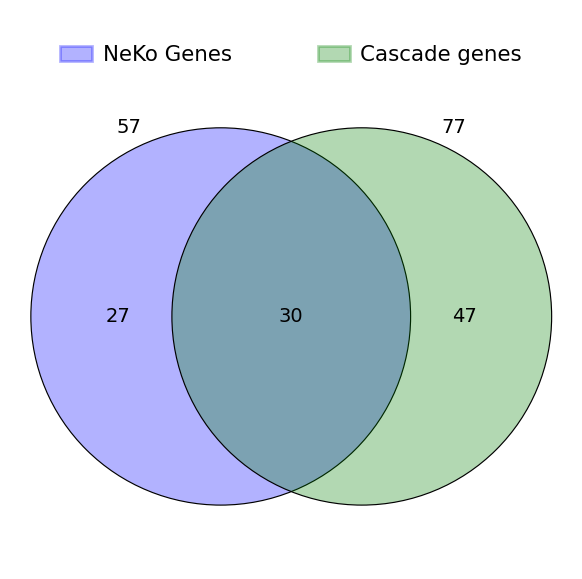

In [65]:
sets = {
    'NeKo Genes': set(set1),
    'Cascade genes': set(set2),
}

venny4py(sets=sets, out='.')

Number of common interactions: 25
Common interactions: {('GSK3B', 'inhibition', 'PTEN'), ('TAB1', 'activation', 'MAP3K7'), ('MAP2K1', 'activation', 'MAPK1'), ('MAPK1', 'inhibition', 'GSK3B'), ('MAP3K7', 'activation', 'MAP2K3'), ('DUSP1', 'inhibition', 'MAPK14'), ('MAPK14', 'activation', 'DUSP1'), ('MAP2K4', 'activation', 'MAPK14'), ('MAPK14', 'inhibition', 'TAB1'), ('AKT1', 'inhibition', 'GSK3A'), ('MAP3K7', 'activation', 'MAP2K4'), ('AKT2', 'inhibition', 'FOXO3'), ('AKT1', 'inhibition', 'BRAF'), ('RAF1', 'activation', 'MAP2K1'), ('AKT2', 'inhibition', 'GSK3B'), ('MAP2K3', 'activation', 'MAPK14'), ('AKT1', 'inhibition', 'RAF1'), ('BRAF', 'activation', 'MAP2K1'), ('GAB2', 'activation', 'PIK3CA'), ('AKT1', 'inhibition', 'FOXO3'), ('MAP3K8', 'activation', 'MAP2K1'), ('MTOR', 'activation', 'AKT1'), ('AKT1', 'inhibition', 'GSK3B'), ('MAPK1', 'inhibition', 'MAP2K1'), ('IRS1', 'activation', 'PIK3CA')}


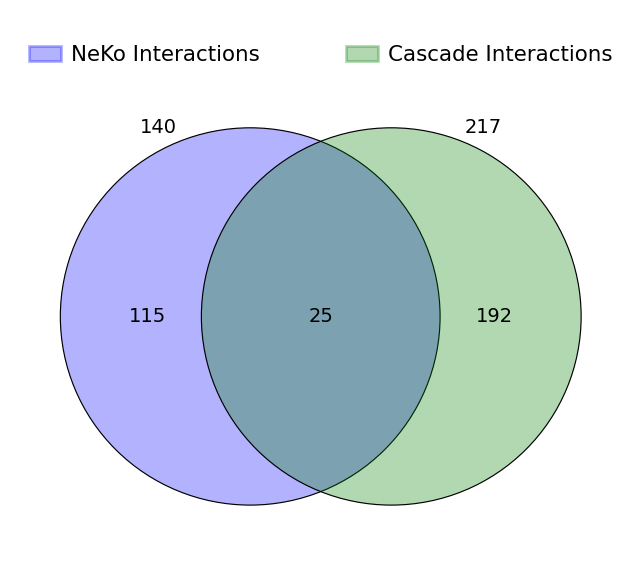

In [61]:
def compare_interactions(df1, df2):
    # Create sets of interactions (source, interaction, target) as tuples
    interactions_set1 = set(df1[['Source', 'Interaction', 'Target']].apply(tuple, axis=1))
    interactions_set2 = set(df2[['Source', 'Interaction', 'Target']].apply(tuple, axis=1))
    
    # Create a dictionary of the two sets for venny4py
    interaction_sets = {
        'NeKo Interactions': interactions_set1,
        'Cascade Interactions': interactions_set2,
    }
    
    # Use the sets to find the intersection (common interactions)
    common_interactions = interactions_set1.intersection(interactions_set2)
    
    # Return the common interactions, their count, and interaction sets for visualization
    return common_interactions, len(common_interactions), interaction_sets

# Example usage:
common_interactions, common_count, interaction_sets = compare_interactions(neko_net, cascade_net)
print(f"Number of common interactions: {common_count}")
print(f"Common interactions: {common_interactions}")

# To visualize with venny4py:
venny4py(sets=interaction_sets, out='.')